In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report
)
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
import os

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Bibliotecas importadas!")

✅ Bibliotecas importadas!


# CARREGAR DADOS COM FEATURES ADICIONAIS

In [2]:
# Carregar dados já processados do reviews_cleaned.json
json_file = '../datasets/reviews_cleaned.json'
print(f"📁 Carregando dados processados: {json_file}")

with open(json_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data)
print(f"✅ Dados carregados: {len(df):,} registros")

# Verificar estrutura dos dados
print(f"\n📋 Colunas disponíveis: {df.columns.tolist()}")
print(f"📊 Distribuição de sentimentos:")
print(df['sentiment'].value_counts())

# Adicionar coluna de recomendação baseada no rating (simplificada)
# Como não temos a coluna original, vamos inferir da combinação rating + sentimento
def infer_recommendation(row):
    """Inferir recomendação baseada em rating e sentimento"""
    rating = row['rating']
    sentiment = row['sentiment']
    
    if rating >= 4 and sentiment == 'Positivo':
        return 'Yes'
    elif rating <= 2 and sentiment == 'Negativo':
        return 'No'
    elif rating == 3:
        return 'Yes' if sentiment == 'Positivo' else 'No'
    else:
        return 'Yes'  # Default para casos neutros/positivos

df['recommend_to_a_friend'] = df.apply(infer_recommendation, axis=1)

print(f"\n📊 Distribuição de recomendações inferidas:")
print(df['recommend_to_a_friend'].value_counts())

📁 Carregando dados processados: ../datasets/reviews_cleaned.json
✅ Dados carregados: 128,971 registros

📋 Colunas disponíveis: ['text', 'sentiment', 'rating']
📊 Distribuição de sentimentos:
sentiment
Positivo    92894
Negativo    33571
Neutro       2506
Name: count, dtype: int64

📊 Distribuição de recomendações inferidas:
recommend_to_a_friend
Yes    95400
No     33571
Name: count, dtype: int64


# VERIFICAR LABELS DE SENTIMENTO (JÁ PROCESSADOS)

In [3]:
# Os sentimentos já estão processados no reviews_cleaned.json
print("✅ Labels de sentimento já processados no dataset!")

# Distribuição de sentimentos
print("\n📊 Distribuição de sentimentos:")
sentiment_dist = df['sentiment'].value_counts()
for sentiment, count in sentiment_dist.items():
    pct = count / len(df) * 100
    print(f"{sentiment:8}: {count:6,} ({pct:5.1f}%)")

# Matriz de confusão: Rating vs Sentimento
print("\n📊 Matriz: Rating vs Sentimento")
confusion = pd.crosstab(df['rating'], df['sentiment'])
print(confusion)

# Estatísticas das features
print("\n📈 Estatísticas das features:")
print(f"Rating médio: {df['rating'].mean():.2f}")
print(f"Recomendações positivas: {df['recommend_to_a_friend'].value_counts()['Yes'] / len(df) * 100:.1f}%")

✅ Labels de sentimento já processados no dataset!

📊 Distribuição de sentimentos:
Positivo: 92,894 ( 72.0%)
Negativo: 33,571 ( 26.0%)
Neutro  :  2,506 (  1.9%)

📊 Matriz: Rating vs Sentimento
sentiment  Negativo  Neutro  Positivo
rating                               
1             25642       0         0
2              6110    2013         0
3              1819       0     14172
4                 0     493     31462
5                 0       0     47260

📈 Estatísticas das features:
Rating médio: 3.52
Recomendações positivas: 74.0%


# FEATURE ENGINEERING

In [4]:
# 1. TF-IDF do texto
print("🔄 Criando features TF-IDF...")
tfidf = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.7
)

X_text = tfidf.fit_transform(df['text'])  # Usar coluna 'text' do JSON
print(f"✅ TF-IDF: {X_text.shape[1]} features de texto")

# 2. Features numéricas
print("\n🔄 Processando features numéricas...")

# Rating normalizado
rating_scaler = StandardScaler()
rating_scaled = rating_scaler.fit_transform(df[['rating']])  # Usar coluna 'rating' do JSON

# Recomendação como dummy
recommend_dummy = (df['recommend_to_a_friend'] == 'Yes').astype(int).values.reshape(-1, 1)

# Features adicionais calculadas
text_length = df['text'].str.len().values.reshape(-1, 1)  # Usar coluna 'text' do JSON
text_length_scaler = StandardScaler()
text_length_scaled = text_length_scaler.fit_transform(text_length)

# Combinar todas as features
from scipy.sparse import hstack
X_combined = hstack([
    X_text,                    # TF-IDF features
    rating_scaled,            # Rating normalizado
    recommend_dummy,          # Recomendação
    text_length_scaled       # Comprimento do texto
])

print(f"✅ Features combinadas: {X_combined.shape[1]} features totais")
print(f"   - TF-IDF: {X_text.shape[1]} features")
print(f"   - Rating: 1 feature")
print(f"   - Recomendação: 1 feature")
print(f"   - Comprimento: 1 feature")

# Target
sentiment_mapping = {'Negativo': 0, 'Neutro': 1, 'Positivo': 2}
y = df['sentiment'].map(sentiment_mapping)

print(f"\n🎯 Target classes: {dict(zip(sentiment_mapping.values(), sentiment_mapping.keys()))}")

🔄 Criando features TF-IDF...
✅ TF-IDF: 1000 features de texto

🔄 Processando features numéricas...
✅ Features combinadas: 1003 features totais
   - TF-IDF: 1000 features
   - Rating: 1 feature
   - Recomendação: 1 feature
   - Comprimento: 1 feature

🎯 Target classes: {0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}


## CALCULAR SAMPLE_WEIGHTS PARA PRIORIZAR PALAVRAS NEGATIVAS

In [5]:
print("CALCULAR SAMPLE_WEIGHT PARA PRIORIZAR PALAVRAS NEGATIVAS")
print("="*50)

# Dicionário de palavras negativas (com pesos)
negative_keywords = {
    'péssimo': 3, 'horrível': 3, 'terrível': 3, 'pior': 2, 'ruim': 2,
    'quebrou': 3, 'quebrado': 3, 'problema': 2, 'problemas': 2,
    'não funciona': 3, 'não recomendo': 3, 'decepção': 2, 'insatisfeito': 2,
    'defeito': 3, 'defeitoso': 3, 'falha': 2, 'falho': 2,
    'lixo': 3, 'desperdício': 2, 'arrependido': 2, 'arrependimento': 2,
    'fraude': 3, 'enganado': 3, 'golpe': 3, 'enganação': 3
}

def count_negative_words(text):
    """Contar palavras negativas no texto"""
    text_lower = text.lower()
    return sum(weight for word, weight in negative_keywords.items() if word in text_lower)

# Calcular peso de negatividade
df['negative_word_count'] = df['text'].apply(count_negative_words)

# Criar sample_weight para dar mais importância aos textos com palavras negativas
def calculate_sample_weight(row):
    base_weight = 1.0
    
    # Se o texto é negativo e tem palavras negativas, aumentar peso
    if row['sentiment'] == 'Negativo' and row['negative_word_count'] > 0:
        base_weight = 1.5 + (row['negative_word_count'] * 0.3)
    
    # Se o texto é positivo e tem palavras negativas, reduzir peso (caso contraditório)
    elif row['sentiment'] == 'Positivo' and row['negative_word_count'] > 0:
        base_weight = 0.5
    
    return min(base_weight, 5.0)

df['sample_weight'] = df.apply(calculate_sample_weight, axis=1)

print(f"\n📊 Análise de Pesos:")
print(f"   Peso médio: {df['sample_weight'].mean():.2f}")
print(f"   Peso máximo: {df['sample_weight'].max():.2f}")
print(f"   Peso mínimo: {df['sample_weight'].min():.2f}")

print(f"\n✅ Sample weights calculados!")

CALCULAR SAMPLE_WEIGHT PARA PRIORIZAR PALAVRAS NEGATIVAS



📊 Análise de Pesos:
   Peso médio: 1.06
   Peso máximo: 4.80
   Peso mínimo: 0.50

✅ Sample weights calculados!


# TREINAR MODELO ENHANCED (Random Forest)

In [6]:
# Split treino/teste (mantém sample_weight alinhado)
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X_combined, y, df['sample_weight'],
    test_size=0.2, 
    random_state=42,
    stratify=y
)

print(f"📊 Split: {X_train.shape[0]} treino, {X_test.shape[0]} teste")

# Treinar Random Forest COM sample_weight
print("\n🔄 Treinando Random Forest com sample_weight...")
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train, sample_weight=w_train)
print("✅ Modelo treinado com pesos customizados!")

# Predições
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\n📊 RESULTADOS - MODELO ENHANCED:")
print("="*50)
print(f"Acurácia:  {accuracy:.4f}")
print(f"Precisão:  {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Relatório detalhado
print("\n📋 RELATÓRIO DETALHADO:")
class_names = ['Negativo', 'Neutro', 'Positivo']
report = classification_report(y_test, y_pred, target_names=class_names)
print(report)

📊 Split: 103176 treino, 25795 teste

🔄 Treinando Random Forest com sample_weight...
✅ Modelo treinado com pesos customizados!

📊 RESULTADOS - MODELO ENHANCED:
Acurácia:  0.9704
Precisão:  0.9837
Recall:    0.9704
F1-Score:  0.9754

📋 RELATÓRIO DETALHADO:
              precision    recall  f1-score   support

    Negativo       1.00      1.00      1.00      6715
      Neutro       0.38      0.80      0.51       501
    Positivo       0.99      0.96      0.98     18579

    accuracy                           0.97     25795
   macro avg       0.79      0.92      0.83     25795
weighted avg       0.98      0.97      0.98     25795



# ANÁLISE DE IMPORTÂNCIA DAS FEATURES

🔍 TOP 20 FEATURES MAIS IMPORTANTES:
0.3137 - recommendation
0.2523 - rating_scaled
0.0400 - nao
0.0168 - excelente
0.0155 - text_length
0.0143 - recomendo
0.0140 - bom
0.0115 - muito
0.0089 - otimo
0.0088 - mas
0.0074 - nao recebi
0.0072 - muito bom
0.0063 - super
0.0061 - nao recomendo
0.0057 - que
0.0055 - recebi
0.0054 - otima
0.0054 - antes do
0.0052 - porem
0.0048 - veio


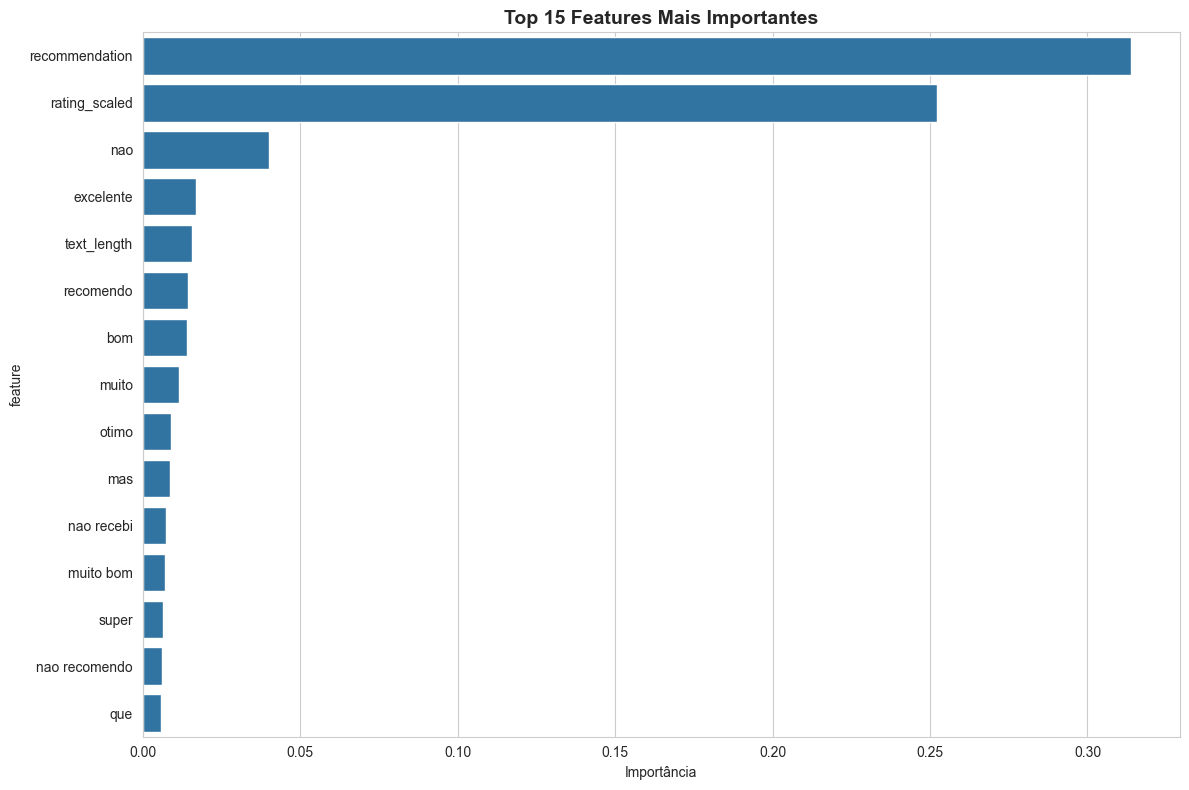


🎯 ANÁLISE DAS FEATURES ESTRUTURADAS:
rating_scaled  : Importância 0.2523 (Rank #1001)
recommendation : Importância 0.3137 (Rank #1002)
text_length    : Importância 0.0155 (Rank #1003)


In [7]:
# Importância das features
feature_names = (
    list(tfidf.get_feature_names_out()) + 
    ['rating_scaled', 'recommendation', 'text_length']
)

importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("🔍 TOP 20 FEATURES MAIS IMPORTANTES:")
print("="*50)
for i, row in feature_importance_df.head(20).iterrows():
    print(f"{row['importance']:.4f} - {row['feature']}")

# Visualizar importância
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(15)
sns.barplot(data=top_features, x='importance', y='feature')
plt.title('Top 15 Features Mais Importantes', fontsize=14, fontweight='bold')
plt.xlabel('Importância')
plt.tight_layout()
plt.show()

# Análise específica das features estruturadas
print("\n🎯 ANÁLISE DAS FEATURES ESTRUTURADAS:")
structured_features = ['rating_scaled', 'recommendation', 'text_length']
for feature in structured_features:
    importance = feature_importance_df[feature_importance_df['feature'] == feature]['importance'].values[0]
    rank = feature_importance_df[feature_importance_df['feature'] == feature].index[0] + 1
    print(f"{feature:15}: Importância {importance:.4f} (Rank #{rank})")

# COMPARAÇÃO: MODELO ORIGINAL vs ENHANCED

🔄 Carregando modelo original para comparação...

📊 COMPARAÇÃO DE MODELOS:
Métrica      Original   Enhanced   Melhoria  
------------------------------------------------------------
Acurácia     0.7763     0.9704     +0.1941 (+25.0%)
Precisão     0.9209     0.9837     +0.0628 (+6.8%)
Recall       0.7763     0.9704     +0.1941 (+25.0%)
F1-Score     0.8377     0.9754     +0.1377 (+16.4%)


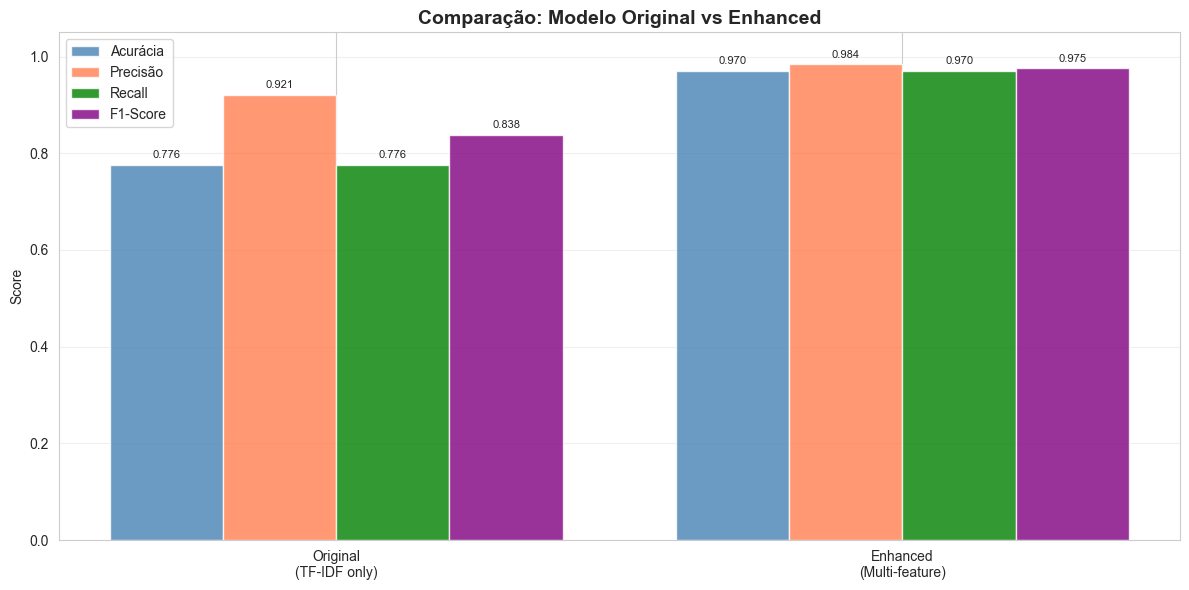


🎯 CONCLUSÃO:
✅ O modelo Enhanced teve 25.0% mais acurácia!
💡 As features adicionais (rating + recomendação) melhoraram a performance!


In [8]:
# Carregar modelo original para comparação
print("🔄 Carregando modelo original para comparação...")

# Modelo original (apenas TF-IDF)
tfidf_original = joblib.load('../models/tfidf_vectorizer.joblib')
model_original = joblib.load('../models/logistic_regression_model.joblib')

# Preparar dados de teste com apenas TF-IDF
X_test_text_only = tfidf_original.transform(df.loc[y_test.index, 'text'])
y_pred_original = model_original.predict(X_test_text_only)

# Métricas do modelo original
accuracy_original = accuracy_score(y_test, y_pred_original)
precision_original = precision_score(y_test, y_pred_original, average='weighted')
recall_original = recall_score(y_test, y_pred_original, average='weighted')
f1_original = f1_score(y_test, y_pred_original, average='weighted')

print("\n📊 COMPARAÇÃO DE MODELOS:")
print("="*60)
print(f"{'Métrica':<12} {'Original':<10} {'Enhanced':<10} {'Melhoria':<10}")
print("-"*60)

metrics = [
    ('Acurácia', accuracy_original, accuracy),
    ('Precisão', precision_original, precision),
    ('Recall', recall_original, recall),
    ('F1-Score', f1_original, f1)
]

for metric_name, original_val, enhanced_val in metrics:
    improvement = enhanced_val - original_val
    improvement_pct = (improvement / original_val) * 100
    print(f"{metric_name:<12} {original_val:.4f}     {enhanced_val:.4f}     {improvement:+.4f} ({improvement_pct:+.1f}%)")

# Visualizar comparação
fig, ax = plt.subplots(figsize=(12, 6))

models = ['Original\n(TF-IDF only)', 'Enhanced\n(Multi-feature)']
accuracies = [accuracy_original, accuracy]
precisions = [precision_original, precision]
recalls = [recall_original, recall]
f1s = [f1_original, f1]

x = np.arange(len(models))
width = 0.2

ax.bar(x - 1.5*width, accuracies, width, label='Acurácia', color='steelblue', alpha=0.8)
ax.bar(x - 0.5*width, precisions, width, label='Precisão', color='coral', alpha=0.8)
ax.bar(x + 0.5*width, recalls, width, label='Recall', color='green', alpha=0.8)
ax.bar(x + 1.5*width, f1s, width, label='F1-Score', color='purple', alpha=0.8)

ax.set_ylabel('Score')
ax.set_title('Comparação: Modelo Original vs Enhanced', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.05])

# Adicionar valores nas barras
for i, (acc, prec, rec, f1_val) in enumerate(zip(accuracies, precisions, recalls, f1s)):
    ax.text(i - 1.5*width, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom', fontsize=8)
    ax.text(i - 0.5*width, prec + 0.01, f'{prec:.3f}', ha='center', va='bottom', fontsize=8)
    ax.text(i + 0.5*width, rec + 0.01, f'{rec:.3f}', ha='center', va='bottom', fontsize=8)
    ax.text(i + 1.5*width, f1_val + 0.01, f'{f1_val:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("\n🎯 CONCLUSÃO:")
if accuracy > accuracy_original:
    print(f"✅ O modelo Enhanced teve {((accuracy - accuracy_original)/accuracy_original*100):.1f}% mais acurácia!")
    print("💡 As features adicionais (rating + recomendação) melhoraram a performance!")
else:
    print("⚠️ O modelo Enhanced não superou o original. Pode ser necessário ajuste de hiperparâmetros.")

# SALVAR MODELO ENHANCED PARA PRODUÇÃO

In [9]:
# Criar diretório se não existir
os.makedirs('../models/enhanced', exist_ok=True)

# Salvar componentes do modelo enhanced
print("💾 Salvando modelo enhanced...")

# TF-IDF
joblib.dump(tfidf, '../models/enhanced/tfidf_vectorizer.joblib')
print("✅ TF-IDF salvo")

# Scaler para rating
joblib.dump(rating_scaler, '../models/enhanced/rating_scaler.joblib')
print("✅ Rating scaler salvo")

# Scaler para text length
joblib.dump(text_length_scaler, '../models/enhanced/text_length_scaler.joblib')
print("✅ Text length scaler salvo")

# Modelo Random Forest
joblib.dump(model, '../models/enhanced/random_forest_model.joblib')
print("✅ Random Forest salvo")

# Mapeamento de sentimentos
with open('../models/enhanced/sentiment_mapping.json', 'w') as f:
    json.dump(sentiment_mapping, f, indent=2)
print("✅ Mapeamento salvo")

# Metadata
metadata = {
    'model_type': 'Random Forest + Multi-feature',
    'features': {
        'tfidf_features': X_text.shape[1],
        'rating': True,
        'recommendation': True,
        'text_length': True
    },
    'accuracy_test': accuracy,
    'precision_test': precision,
    'recall_test': recall,
    'f1_test': f1,
    'classes': ['Negativo', 'Neutro', 'Positivo'],
    'training_samples': X_train.shape[0],
    'test_samples': X_test.shape[0]
}

with open('../models/enhanced/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("✅ Metadata salva")

print(f"\n🎉 Modelo Enhanced salvo em: ../models/enhanced/")
print(f"📊 Acurácia esperada: {accuracy:.4f}")
print("\n💡 Para usar em produção, será necessário modificar a API para aceitar rating e recomendação!")

💾 Salvando modelo enhanced...
✅ TF-IDF salvo
✅ Rating scaler salvo
✅ Text length scaler salvo
✅ Random Forest salvo
✅ Mapeamento salvo
✅ Metadata salva

🎉 Modelo Enhanced salvo em: ../models/enhanced/
📊 Acurácia esperada: 0.9704

💡 Para usar em produção, será necessário modificar a API para aceitar rating e recomendação!
